In [1]:
from test_fair_clustering import main
import argparse
import os
import csv
import json
%matplotlib inline

from alter_data import convert_data_columns

from notebook_utils.filtering import find_same_options
from notebook_utils.saving import make_csv, make_save_dict, make_save_dict_Lipschitz, convert_args_for_kernel_save
from notebook_utils.fetching_and_printing import fetch_and_print, fetch_and_print_Lipschitz
from data_visualization import plot_fairness_vs_clusterE
from src.dataset_load import read_dataset

# Imports for Bera et al. baseline
import configparser
from bera.fair_clustering import fair_clustering
from bera.util.configutil import read_list
from bera.get_results import convert_bera

In [2]:
OUTPUT_FOLDER       = "outputs"
DATA_FOLDER         = "data"
CSV_NAME            = "results.csv"
CSV_NAME_LIPSCHITZ  = "results_Lipschitz.csv"
FINAL_RESULTS_NAME  = "final_results.json"

DEFAULT_RUNS = 30
DEFAULT_REPROD_L = 2.0
MODES = ["reprod", "lmbda_reprod", "Lipz_replic", "extra_datasets", "kernel_baseline", "kernel_poly", "kernel_tanh", "kernel_radial"]

N_RUNS_LIPSCHITZ = 10
LIPSCHITZ_CONSTANTS = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0]

REPRODUCE = False
"""Run everything again if REPRODUCE"""
TEST_RUN = False
"""Run a single test run for all configs if TEST_RUN"""

KERNEL_RUNS = 1

In [3]:
if REPRODUCE:
    CSV_NAME = "new_results.csv"
    CSV_NAME_LIPSCHITZ = "new_results_Lipschitz.csv"
elif TEST_RUN:
    DEFAULT_RUNS = 1
    N_RUNS_LIPSCHITZ = 1
    # DEFAULT_REPROD_L = 1e-4 # For faster testing
    CSV_NAME = "testrun_results.csv"
    CSV_NAME_LIPSCHITZ = "testrun_results_Lipschitz.csv"

In [4]:
# Synthetic kmedian reprod got consistently bad results
# Synthetic kmeans reprod gets perfect results only on some seeds
# Synthetic-unequal kmeans reprod gets perfect reproduction without seeds 20, 22 and 24
# Census II ncut reprod maybe would've worked with lmbda < 100 but not enough time to experiment

# Load configs
with open("notebook_utils/configurations.json", "r") as f:
    configs = json.load(f)

# Load additional configs just for displaying results
with open("notebook_utils/configurations_additional.json", "r") as f:
    configs_additional = json.load(f)

# Preprocess Student dataset
base_path = os.path.join('Student', 'student_mat_Cortez')
if os.path.isfile(os.path.join(DATA_FOLDER, base_path+".csv")) and not os.path.isfile(os.path.join(DATA_FOLDER, base_path+"_sexmod.csv")):
    convert_data_columns(base_path+".csv", base_path+"_sexmod.csv", 1, [('M', 0), ('F', 1)])

In [5]:
def get_args(seed: int=1, dataset: str="Synthetic-unequal", cluster_option: str="ncut", lmbda: float=None, lmbda_tune: bool=False, Lipschitz: float=None, bound_update_test: bool=False, kernel_type=None) -> argparse.Namespace:
    """
    Return Namespace instance with passed and default arguments for main().

    :param bound_update_test: if True, lets main() return a list of energies of a single bound update. Meant for checking convergence.
    :param for the rest see test_fair_clustering.py:

    :return Namespace instance with passed and default arguments for main()
    """
    args = argparse.Namespace()
    
    args.plot_option_clusters_vs_lambda = False     # Only available for the synthetic datasets
    args.plot_option_fairness_vs_clusterE = True    # Only works when lmbda_tune == True
    args.plot_option_balance_vs_clusterE = False    # Only works when lmbda_tune == True
    args.plot_option_convergence = False
    args.bound_update_test = bound_update_test      # Return a list of the energies of a single bound update
    
    args.bera = False

    if kernel_type:
        args.kernel_type = kernel_type
    else:
        args.kernel_type = "poly"
    
    if args.kernel_type in ["poly", "tanh"]:
        args.kernel_args = "2_2"
    elif args.kernel_type == "radial":
        args.kernel_args = "2_2"
    else:
        print(f"kernel_type: {args.kernel_type} not valid")

    args.seed = seed
    args.dataset = dataset
    args.cluster_option = cluster_option
    args.lmbda_tune = lmbda_tune

    if lmbda:
        args.lmbda = lmbda
    else:
        args.lmbda = configs[dataset][cluster_option]["reprod"]["lmbda"]
    
    if Lipschitz:
        args.L = Lipschitz
    elif "Lipschitz" in configs[dataset][cluster_option]["reprod"]:
        args.L = configs[dataset][cluster_option]["reprod"]["Lipschitz"]
    else:
        args.L = DEFAULT_REPROD_L

    working_dir = os.getcwd()
    args.data_dir = os.path.join(working_dir, DATA_FOLDER)
    args.output_path = os.path.join(working_dir, OUTPUT_FOLDER)
    return args


def run_main(args: argparse.Namespace, csv_name: str=CSV_NAME) -> None:
    """
    Run main and append results with config to csv file.
    File is automatically made if it doesn't exist yet.

    :param args: Namespace instance with arguments for main()
    :param csv_name: just the filename of the csv, eg "results.csv"
    """
    results = main(args, logging=False, seedable=True)
    
    save_dict = make_save_dict(convert_args_for_kernel_save(args), results)

    # Make csv if necessary and save row
    csv_path = os.path.join(args.output_path, csv_name)
    fieldnames = save_dict.keys()
    make_csv(args.output_path, csv_path, fieldnames)
    with open(csv_path, "a", newline='') as f:
        writer = csv.DictWriter(f, fieldnames)
        writer.writerow(save_dict)
    

In [6]:
"""Execute one run"""
# run_main(get_args(
#     seed = 3, 
#     dataset = "CensusII",
#     cluster_option = "ncut", 
#     lmbda = .5,
#     # lmbda_tune = True, 
#     Lipschitz = 1e-5,     # Lipschitz constant
# ))

'Execute one run'

In [7]:
"""Run all configs with different seeds"""

# Make sure the csv is there
args = get_args()
csv_path = os.path.join(args.output_path, CSV_NAME)
fieldnames = make_save_dict(args).keys()
make_csv(args.output_path, csv_path, fieldnames)

for mode in MODES:
    for dataset in configs:
        for cluster_option in configs[dataset]:
            if mode not in configs[dataset][cluster_option]:
                continue

            # Get specified parameters for this config, else get the default
            lmbda = configs[dataset][cluster_option][mode]["lmbda"]
            L = DEFAULT_REPROD_L             
            if "Lipschitz" in configs[dataset][cluster_option][mode]:
                L = configs[dataset][cluster_option][mode]["Lipschitz"]
            n_runs = DEFAULT_RUNS
            if "runs" in configs[dataset][cluster_option][mode]:
                n_runs = min(DEFAULT_RUNS, configs[dataset][cluster_option][mode]["runs"])

            kernel_type = None
            if "kernel" in mode:
                n_runs = KERNEL_RUNS # For lack of time
                if mode.split("_")[1] != "baseline":
                    kernel_type = mode.split("_")[1]

            args = get_args(dataset=dataset, cluster_option=cluster_option, lmbda=lmbda, Lipschitz=L, kernel_type=kernel_type)

            # Find existing entries with same config in the csv
            check_args = convert_args_for_kernel_save(args)
            existing_entries = find_same_options(CSV_NAME, check_args)
            if len(existing_entries) >= n_runs:
                print(f"enough {mode} results for {cluster_option} on {dataset}")
                continue

            # Run n_todo times with different seeds
            n_todo = n_runs - len(existing_entries)

            seeds = [int(entry["seed"]) for entry in existing_entries]
            seeds.append(0) # Make sure seeds is not empty
            next_seed = max(seeds) + 1

            for new_seed in range(next_seed, next_seed + n_todo):
                args.seed = new_seed
                print()
                run_main(args, CSV_NAME)

enough reprod results for kmedian on Synthetic
enough reprod results for kmeans on Synthetic
enough reprod results for ncut on Synthetic
enough reprod results for kmedian on Synthetic-unequal
enough reprod results for kmeans on Synthetic-unequal
enough reprod results for ncut on Synthetic-unequal
enough reprod results for kmedian on Adult
enough reprod results for kmeans on Adult
enough reprod results for ncut on Adult
enough reprod results for kmedian on Bank
enough reprod results for kmeans on Bank
enough reprod results for ncut on Bank
enough reprod results for kmedian on CensusII
enough reprod results for kmeans on CensusII
enough reprod results for ncut on CensusII
enough lmbda_reprod results for kmedian on Synthetic
enough lmbda_reprod results for kmeans on Synthetic
enough Lipz_replic results for kmedian on Adult
enough Lipz_replic results for kmeans on Adult
enough Lipz_replic results for ncut on Adult
enough Lipz_replic results for kmedian on Bank
enough Lipz_replic results fo

In [8]:
"""Fetch results from the csv"""

fetch_and_print(configs, configs_additional, get_args, MODES, DEFAULT_REPROD_L, CSV_NAME, FINAL_RESULTS_NAME)    



REPROD

  Synthetic

    KMEDIAN
    lmbda=10, Lipschitz=2.0, runs=30
      Objective           M = 289.079         SD = 2.033     (0.7%)
      fairness error      M = 0.820           SD = 1.053     (128.5%)
      balance             M = 0.338           SD = 0.205     (60.6%)
      time                M = 4.783           SD = 1.654     (34.6%)

    KMEANS
    lmbda=10, Lipschitz=2.0, runs=30
      Objective           M = 203.663         SD = 2.553     (1.3%)
      fairness error      M = 2.428           SD = 1.468     (60.5%)
      balance             M = 0.274           SD = 0.438     (159.8%)
      time                M = 4.590           SD = 2.285     (49.8%)

    NCUT
    lmbda=10, Lipschitz=1.0, runs=30
      Objective           M = 0.198           SD = 0.100     (50.6%)
      fairness error      M = 0.000           SD = 0.000     (nan%)
      balance             M = 0.979           SD = 0.017     (1.7%)
      time                M = 5.767           SD = 1.937     (33.6%)

  Syn

Lipschitz: 2.0


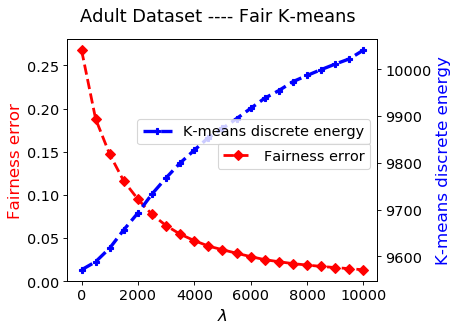

Lipschitz: 0.001


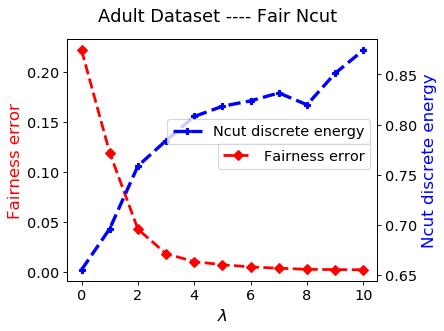

Lipschitz: 2.0


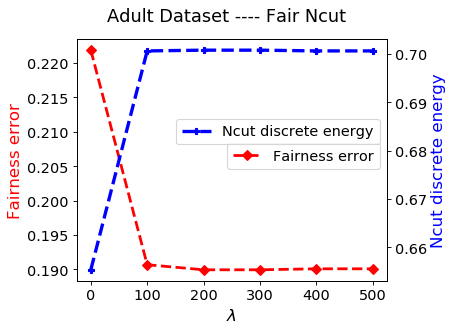

Lipschitz: 2.0


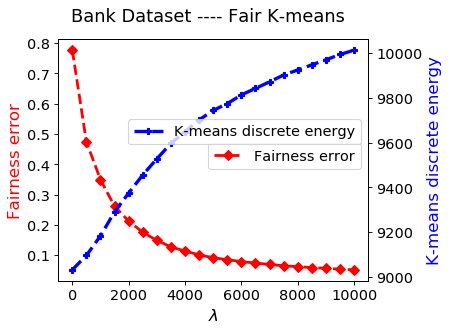

Lipschitz: 0.001


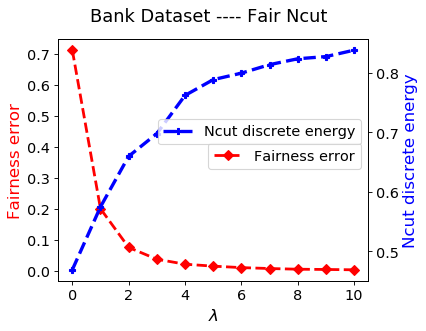

Lipschitz: 2.0


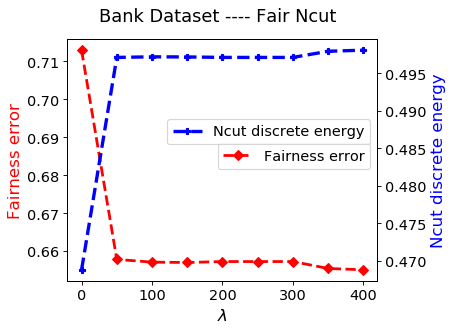

In [9]:
"""Run and plot lmbda tune for different configs"""

for dataset in ["Adult", "Bank"]:
    for cluster_option in ["kmeans", "ncut"]:
        L_list = [2.0]
        if cluster_option == "ncut":
            L_list = [0.001, 2.0]
        for L in L_list:
            name = f'Fair_{cluster_option}_fairness_vs_clusterEdiscrete_Lip{L}_{dataset}'
            savefile = os.path.join("outputs", dataset, name+'.npz')
            filename = os.path.join("outputs", dataset, name+'.png')

            if not os.path.exists(savefile) or TEST_RUN:
                run_main(get_args(1, dataset, cluster_option, lmbda_tune=True, Lipschitz=L))
            
            print(f"Lipschitz: {L}")
            plot_fairness_vs_clusterE(cluster_option, savefile, filename, None, None, None, None, None, save=False, save_without_title=True)

In [10]:
def run_Lipschitz_test(args, csv_name=CSV_NAME_LIPSCHITZ):
    """
    Run bound update and append results with config to csv file.
    File is automatically made if it doesn't exist yet.
    Logs of energy values by iteration are saved to json files, the path to which is saved in a csv field.

    :param args: Namespace instance with arguments for main()
    :param csv_name: just the filename of the csv, eg "results_Lipschitz.csv"
    """
    args.bound_update_test = True
    bound_energy_list, elapsed = main(args, logging=False, seedable=True)

    # Save bound_energy_list separately because it's often too large for csv
    list_dir = os.path.join(args.dataset, "Lipschitz_energy_list_logs")
    os.makedirs(os.path.join(args.output_path, list_dir), exist_ok=True)
    list_filepath = os.path.join(list_dir, f"{args.cluster_option}__L={args.L}__lmb={args.lmbda}__seed={args.seed}.json")
    list_filepath_full = os.path.join(args.output_path, list_filepath)
    with open(list_filepath_full, "w") as f:
        json.dump(bound_energy_list, f, indend=4)

    save_dict = make_save_dict_Lipschitz(args, bound_energy_list, elapsed, list_filepath)

    # Make csv if necessary and save row
    csv_path = os.path.join(args.output_path, csv_name)
    fieldnames = save_dict.keys()
    make_csv(args.output_path, csv_path, fieldnames)
    with open(csv_path, "a", newline='') as f:
        writer = csv.DictWriter(f, fieldnames)
        writer.writerow(save_dict)

In [11]:
"""Run Lipschitz test for multiple configs"""

# Make sure the csv is there
args = get_args()
csv_path = os.path.join(args.output_path, CSV_NAME_LIPSCHITZ)
fieldnames = make_save_dict_Lipschitz(args).keys()
make_csv(args.output_path, csv_path, fieldnames)

use_datasets = [
    # "Synthetic", 
    # "Synthetic-unequal", 
    "Adult", "Bank"]
use_cluster_options = ["kmedian", "kmeans", "ncut"]
for dataset in use_datasets:
    for cluster_option in use_cluster_options:
        for L in LIPSCHITZ_CONSTANTS:
            # Get specified parameters for this config, else get the default
            args = get_args(dataset=dataset, cluster_option=cluster_option, lmbda=1, Lipschitz=L, bound_update_test=True)

            # Find existing entries with same config in the csv
            existing_entries = find_same_options(CSV_NAME_LIPSCHITZ, args, keys=["dataset", "cluster_option", "L"])
            if len(existing_entries) >= N_RUNS_LIPSCHITZ:
                print(f"enough results for bound update test with {cluster_option} on {dataset} with Lipschitz = {L}")
                continue

            # Run n_todo times with different seeds
            n_todo = N_RUNS_LIPSCHITZ - len(existing_entries)

            seeds = [int(entry["seed"]) for entry in existing_entries]
            seeds.append(0) # Make sure seeds is not empty
            next_seed = max(seeds) + 1

            for new_seed in range(next_seed, next_seed + n_todo):
                args.seed = new_seed
                print()
                run_Lipschitz_test(args, CSV_NAME_LIPSCHITZ)

enough results for bound update test with kmedian on Adult with Lipschitz = 1e-05
enough results for bound update test with kmedian on Adult with Lipschitz = 0.0001
enough results for bound update test with kmedian on Adult with Lipschitz = 0.001
enough results for bound update test with kmedian on Adult with Lipschitz = 0.01
enough results for bound update test with kmedian on Adult with Lipschitz = 0.1
enough results for bound update test with kmedian on Adult with Lipschitz = 1.0
enough results for bound update test with kmedian on Adult with Lipschitz = 2.0
enough results for bound update test with kmeans on Adult with Lipschitz = 1e-05
enough results for bound update test with kmeans on Adult with Lipschitz = 0.0001
enough results for bound update test with kmeans on Adult with Lipschitz = 0.001
enough results for bound update test with kmeans on Adult with Lipschitz = 0.01
enough results for bound update test with kmeans on Adult with Lipschitz = 0.1
enough results for bound upda




Adult
  KMEDIAN

    Lipschitz = 1e-05       without 1 outliers: {'10'}
      convergence_iter    M = 8.444           SD = 1.641     (19.4%)
      optimum             M = 19497.172       SD = 261.307   (1.3%)
      time                M = 0.770           SD = 0.115     (15.0%)

    Lipschitz = 0.0001       without 1 outliers: {'8'}
      convergence_iter    M = 6.333           SD = 1.155     (18.2%)
      optimum             M = 19358.479       SD = 322.060   (1.7%)
      time                M = 0.676           SD = 0.053     (7.9%)

    Lipschitz = 0.001       without 0 outliers: set()
      convergence_iter    M = 7.200           SD = 0.400     (5.6%)
      optimum             M = 19413.878       SD = 349.161   (1.8%)
      time                M = 0.451           SD = 0.021     (4.7%)

    Lipschitz = 0.01       without 0 outliers: set()
      convergence_iter    M = 11.200          SD = 0.400     (3.6%)
      optimum             M = 19414.184       SD = 349.183   (1.8%)
      tim

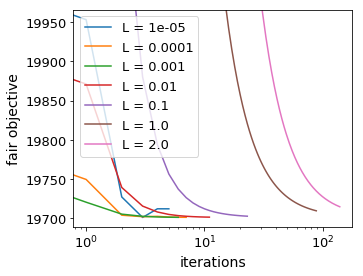

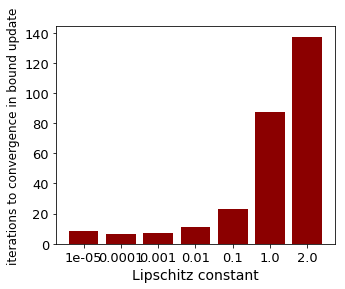

Adult
  KMEANS

    Lipschitz = 1e-05       without 1 outliers: {'7'}
      convergence_iter    M = 6.889           SD = 1.449     (21.0%)
      optimum             M = 13150.325       SD = 416.009   (3.2%)
      time                M = 0.658           SD = 0.074     (11.2%)

    Lipschitz = 0.0001       without 0 outliers: set()
      convergence_iter    M = 6.300           SD = 1.552     (24.6%)
      optimum             M = 13160.706       SD = 395.790   (3.0%)
      time                M = 0.496           SD = 0.127     (25.6%)

    Lipschitz = 0.001       without 0 outliers: set()
      convergence_iter    M = 7.000           SD = 0.447     (6.4%)
      optimum             M = 13160.557       SD = 395.826   (3.0%)
      time                M = 0.463           SD = 0.016     (3.4%)

    Lipschitz = 0.01       without 1 outliers: {'10'}
      convergence_iter    M = 11.000          SD = 0.000     (0.0%)
      optimum             M = 13246.333       SD = 317.549   (2.4%)
      time  

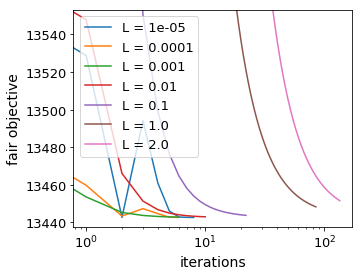

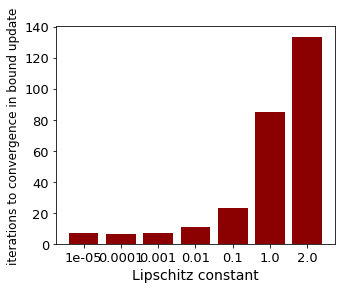

Adult
  NCUT

    Lipschitz = 1e-05       without 1 outliers: {'8'}
      convergence_iter    M = 5.000           SD = 0.000     (0.0%)
      optimum             M = 0.000           SD = 0.000     (nan%)
      time                M = 0.588           SD = 0.024     (4.1%)

    Lipschitz = 0.0001       without 1 outliers: {'1'}
      convergence_iter    M = 5.222           SD = 0.416     (8.0%)
      optimum             M = 0.000           SD = 0.000     (nan%)
      time                M = 0.394           SD = 0.017     (4.3%)

    Lipschitz = 0.001       without 2 outliers: {'2', '5'}
      convergence_iter    M = 211.750         SD = 9.769     (4.6%)
      optimum             M = -8.663          SD = 0.066     (-0.8%)
      time                M = 7.391           SD = 0.370     (5.0%)

    Lipschitz = 0.01       without 0 outliers: set()
      convergence_iter    M = 501.600         SD = 10.965    (2.2%)
      optimum             M = -8.660          SD = 0.063     (-0.7%)
      time  

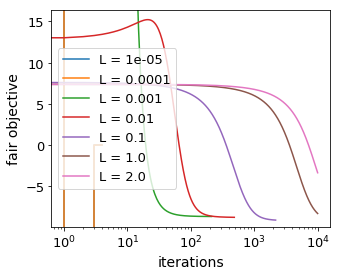

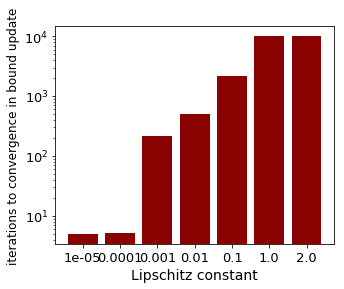




Bank
  KMEDIAN

    Lipschitz = 1e-05       without 1 outliers: {'3'}
      convergence_iter    M = 5.222           SD = 0.629     (12.0%)
      optimum             M = 21904.423       SD = 534.549   (2.4%)
      time                M = 0.979           SD = 0.110     (11.2%)

    Lipschitz = 0.0001       without 0 outliers: set()
      convergence_iter    M = 5.100           SD = 0.539     (10.6%)
      optimum             M = 21859.493       SD = 524.808   (2.4%)
      time                M = 0.814           SD = 0.047     (5.8%)

    Lipschitz = 0.001       without 2 outliers: {'10', '8'}
      convergence_iter    M = 7.000           SD = 0.000     (0.0%)
      optimum             M = 21752.772       SD = 522.968   (2.4%)
      time                M = 0.980           SD = 0.047     (4.8%)

    Lipschitz = 0.01       without 0 outliers: set()
      convergence_iter    M = 11.700          SD = 0.458     (3.9%)
      optimum             M = 21859.987       SD = 524.837   (2.4%)
     

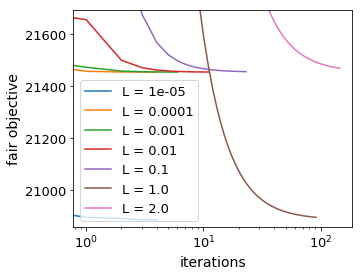

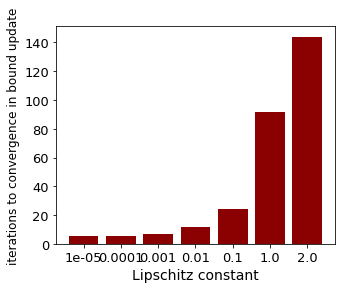

Bank
  KMEANS

    Lipschitz = 1e-05       without 0 outliers: set()
      convergence_iter    M = 4.700           SD = 1.187     (25.3%)
      optimum             M = 13366.633       SD = 596.429   (4.5%)
      time                M = 0.471           SD = 0.066     (14.1%)

    Lipschitz = 0.0001       without 1 outliers: {'10'}
      convergence_iter    M = 5.333           SD = 0.667     (12.5%)
      optimum             M = 13349.707       SD = 626.445   (4.7%)
      time                M = 0.528           SD = 0.037     (7.0%)

    Lipschitz = 0.001       without 0 outliers: set()
      convergence_iter    M = 7.400           SD = 0.490     (6.6%)
      optimum             M = 13366.766       SD = 596.471   (4.5%)
      time                M = 0.653           SD = 0.031     (4.7%)

    Lipschitz = 0.01       without 0 outliers: set()
      convergence_iter    M = 12.400          SD = 0.490     (4.0%)
      optimum             M = 13366.981       SD = 596.458   (4.5%)
      time    

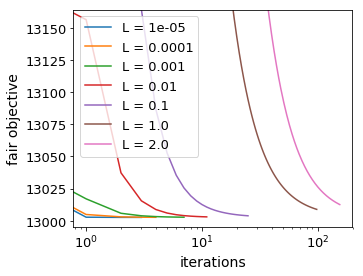

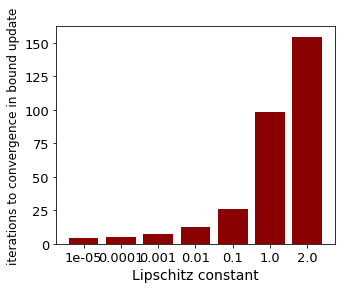

Bank
  NCUT

    Lipschitz = 1e-05       without 1 outliers: {'7'}
      convergence_iter    M = 34.556          SD = 49.397    (142.9%)
      optimum             M = -3.078          SD = 4.353     (-141.4%)
      time                M = 2.134           SD = 2.534     (118.7%)

    Lipschitz = 0.0001       without 2 outliers: {'2', '10'}
      convergence_iter    M = 116.875         SD = 9.506     (8.1%)
      optimum             M = -9.244          SD = 0.033     (-0.4%)
      time                M = 6.025           SD = 0.455     (7.6%)

    Lipschitz = 0.001       without 0 outliers: set()
      convergence_iter    M = 188.800         SD = 3.842     (2.0%)
      optimum             M = -9.241          SD = 0.033     (-0.4%)
      time                M = 9.283           SD = 0.193     (2.1%)

    Lipschitz = 0.01       without 0 outliers: set()
      convergence_iter    M = 451.100         SD = 10.492    (2.3%)
      optimum             M = -9.240          SD = 0.034     (-0.4%)
    

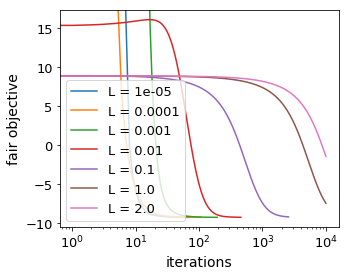

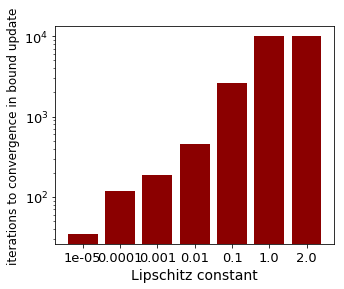

In [12]:
"""Fetch Lipschitz results from the csv and make plots"""

fetch_and_print_Lipschitz(use_datasets, use_cluster_options, get_args, LIPSCHITZ_CONSTANTS, CSV_NAME_LIPSCHITZ)

In [17]:
"""Calculate Bera et al. K-means baseline results"""

dataset = "Student"
if dataset.lower() not in convert_bera():
    config_file = os.path.join("bera", "config", "dataset_configs.ini")
    config = configparser.ConfigParser(converters={'list': read_list})
    config.read(config_file)
    config_str = dataset.lower()

    data, demograph, K = read_dataset(dataset, os.path.join("data", dataset))

    print("Using config_str = {}".format(config_str))

    # Read variables
    output_dir = os.path.join("bera", "output")
    dataset = config[config_str].get("dataset")
    clustering_config_file = config_file
    num_clusters = K
    deltas = [0.9]
    max_points = config[config_str].getint("max_points")
    violating = config["DEFAULT"].getboolean("violating")
    violation = config["DEFAULT"].getfloat("violation")
    violating = False

    fair_clustering(config_str, clustering_config_file, output_dir, num_clusters, deltas, max_points, violating, violation)

In [15]:
"""Convert Bera et al. results to Ziko et al. metrics"""

bera_datasets = convert_bera()
for dataset in bera_datasets:
    if dataset.title() != "Student":
        continue

    args = get_args(dataset=dataset.title(), cluster_option="kmeans", lmbda="N/A", Lipschitz="N/A")
    args.bera = True
    main(args, logging=False, seedable=True)

Seed: 1
Cluster number for dataset Student is 2
Balance of the dataset 0.8990384615384616
Number of points in the dataset 395
Demographic-probabilites: [0.5265822784810127, 0.47341772151898737]
Demographic-numbers per group: [208, 187]
Lipschitz constant: N/A
Generating initial seeds
Inside Lambda  N/A
lambda = N/A, 
 fairness_error  0.00 and 
 avg_balance =  0.85 
 min_balance =  0.78
Best fairness_error 0.0024 |Error lambda =  N/A
Best  Avg balance 0.8539 | Avg Balance lambda =  N/A
Best  Min balance 0.7838 | Min Balance lambda =  N/A
Best  Coef 0.0751 | Min Coef lambda =  N/A
avg elapsed  0.0
[0.07509672072756285]
